# Chapter 4 Tutorial

In this tutorial, we use Twitter data to create and explore directed networks of social interactions.

Contents:

* Preface: Twitter API access


1. Authenticating with Twitter's API
2. Twitter API basics
3. Using Twitter's search API to get tweets of interest
4. Creating social network graphs
5. Twitter retweet network
6. Twitter mention network

# Preface: Twitter API access

In order to get Twitter data using their API, one must first have a Twitter App. In Twitter parlance, an "app" is just a pair of API keys, ostensibly used for a particular purpose; this doesn't mean that we are creating an application to run on mobile or desktop computers. Unfortunately, creating a Twitter App requires access to Twitter's developer platform, which requires an application process with Twitter. Instructors and students have three basic options on how to proceed for this tutorial.

**Team member app:** In the first of these options, the instructor
applies for and obtains organizational access to the developer platform following [Twitter's Playbook for Educators](https://developer.twitter.com/en/docs/basics/developer-portal/guides/twitter-for-education).
Then the instructor invites students as team members. Each student subsequently creates their own Twitter App for use with this tutorial.
The downside to this option is that the application for organizational access is somewhat involved and approval takes significant time. In addition, this reqires an additional step of students accepting their invitations to the team, which currently requires each student's Twitter account to have email notifications enabled. As the Twitter-official recommendation, we expect this workflow to improve over time.

**Shared course app:** In this workflow, the instructor
[applies for and obtains access](https://developer.twitter.com/en/apply-for-access)
to the developer platform, creates a single app for classroom use, then shares the app keys with the students. Since more than one user can authenticate with an app, this is enough to get a classroom of students access to Twitter's APIs. The downside here is security: with all students sharing a single app, the potential exists for a single student's actions to get the app's access revoked, negatively affecting the rest of the class. This is the recommended workflow for someone using these materials for small classes or self-study where the extra steps in the organizational workflow are unnecessary.

**No app:** Due to the approval process for Twitter API access taking a significant amount of time, we have provided a file containing Twitter data that can be used for this tutorial. Of course this is less exciting than getting real data on a topic of your choice, but this backup is better than nothing. The file `science_tweets.json` is located in the `datasets` directory and can be loaded like this:

    import json
    search_tweets = json.load(open('../datasets/science_tweets.json'))

In this case, you could skip the first section on authentication and read sections 2-4 without running the code. By replacing the code in 5.1 and 6.1 with the above snippet, the code in those sections can then be edited and executed.


# 1. Authenticating with Twitter's API

Twitter uses OAuth in order to allow third-party apps to access data on your behalf without requiring your Twitter login credentials -- note that none of the code in this notebook asks for your Twitter screen name or password.

The OAuth "dance" can be intimidating when you first use it, but it provides a far more secure way for software to make requests on your behalf than providing your username and password.

We'll make use of the
[Twython](https://twython.readthedocs.io/en/latest/usage/starting_out.html#authentication)
package to help us with authentication and querying Twitter's APIs.

In [ ]:
from twython import Twython

For this tutorial, we'll be using a developer workflow where we assume you have access to an app's API key and secret. The app could be a team mamber app or a shared course app, as explained above.

## 1.1 Enter app info and get auth URL

In order to authenticate with Twitter, we'll provide the app details and  ask for a one-time authorization URL to authenticate your user with this app.

Copy and paste the API key and secret from your Twitter app into the first two lines below.

Executing the cell should then print out a clickable URL. This link is unique and will work **exactly** once. Visit this URL, log into Twitter, and then copy the verifier pin that is given to you so as to paste it in the next step.

In [ ]:
API_KEY = 'xxxxxxxxxxxx'
API_SECRET_KEY = 'xxxxxxxxxxxxxxxxxxxxxxxxx'

twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

## 1.2 Authorize app using verifier PIN

That verifier PIN goes into the next cell. This will be different every time you run these steps. The `authentication_tokens` include temporary tokens that go with this verifier PIN; by submitting these together, we show Twitter that we are who we say we are.

In [ ]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '0000000'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)

Note: If you are using your own team member app, you could alternatively obtain a permanent token pair (OAuth access token and secret) directly from the [Twitter app dashboard](https://developer.twitter.com/en/apps).

## 1.3 Use authorized tokens

Now we have a permanent token pair that we can use to make authenticated calls to the Twitter API. We'll create a new Twython object using these authenticated keys and verify the credentials of the logged-in user.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

If the previous cell ran without error and printed out a dict corresponding to a
[Twitter User](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
then you're good. The authorized token pair is like a username/password and should be protected as such.

# 2. Twitter API basics

In this tutorial, we'll be dealing with two different types of data, Users and Tweets.

## 2.1 User objects

We've already seen one
[User Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
the one corresponding to the logged-in user, via the call to  `verify_credentials()` above. We can also fetch data for an arbitrary user:

In [ ]:
user = twitter.show_user(screen_name='OSoMe_IU')
user

This dictionary of user data contains several items of note. First, the screen name of the user, while obvious in this case, is very useful later:

In [ ]:
user['screen_name']

The user data also contains information such as the number of followers, friends (other users followerd by this user), and tweets (called `'statuses'` in the API):

In [ ]:
print("""
Twitter user @{screen_name}
has {followers_count} followers,
follows {friends_count} users,
and has tweeted {statuses_count} times.
""".format(**user))

## 2.2 Tweet Objects

The second type of data of which we will make use is the
[Tweet Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).
A user object actually contains the user's most recent tweet:

In [ ]:
most_recent_tweet = user['status']
most_recent_tweet

Tweet objects contain several interesting data and metadata, but the most basic are the `'text'` and `'entities'`. The `'text'` is what you expect it to be: the text of the tweet:

In [ ]:
most_recent_tweet['text']

The `'entities'` field contains several tokens of interest already extracted from the tweet such as hashtags, URLs, images, and mentions of other users:

In [ ]:
most_recent_tweet['entities']

In particular, we'll make use of the `'user_mentions'` later:

In [ ]:
most_recent_tweet['entities']['user_mentions']

# 3. Using Twitter's search API to get tweets of interest

Twitter's
[Search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html)
allows you to fetch recent tweets according to a query of keywords, URLs, hashtags, user mentions, etc.

## 3.1 Get tweets matching a hashtag

We'll make use of the ability to search by hashtags:

In [ ]:
search_response = twitter.search(q='#science', count=100)

While the search API response is a dictionary, the `'statuses'` field contains the list of
[Tweet Objects](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)
we're after.

In [ ]:
search_tweets = search_response['statuses']
tweet = search_tweets[0]
tweet

Note that each tweet obtained from this API contains a `'user'` field -- this is a User Object for the user who created the tweet.

In [ ]:
tweet['user']

## 3.2 Using a cursor to get more than 100 tweets from a search

We can only fetch up to 100 tweets at a time from a single search API call:

In [ ]:
# even with count=1000, we still get at most 100 tweets
search_response = twitter.search(q='#science', count=1000)
len(search_response['statuses'])

In order to get more tweets from a search, we can make use of a cursor:

In [ ]:
import itertools

NUM_TWEETS_TO_FETCH = 1000

cursor = twitter.cursor(twitter.search, q='#science', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

In [ ]:
type(cursor)

Note the following:
* The cursor object is a
[generator](https://docs.python.org/3/tutorial/classes.html#generators),
a type of iterator that "lazily" generates items. We use Python's `itertools.islice` in order to get up to a set number of items from this generator. The second argument passed to `islice` is the max number of tweets we want to fetch from the user.
* Even though we want to get more than 100 tweets here, we provide the `count=100` argument. This tells the cursor to fetch the maximum number of tweets with each API call.
* As documented in [Twitter's Search API documentation](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html), specifying `result_type='mixed'` provides a mix of recent and popular tweets matching the query. If one desires a more "random" sample, you can specify `result_type='recent'`, but Twitter may provide fewer tweets than desired.
* We provide the API function name as the first argument followed by the function's arguments. It's tempting but **incorrect** to do the following:

      cursor = twitter.cursor(twitter.get_user_timeline(screen_name='osome_iu', count=200))


## 3.3 API method rate limits

Each API method has a *rate limit* imposed by Twitter, a limit on the number of function calls per 15-minute window. We can check on the rate limit status for this endpoint:

In [ ]:
twitter.get_application_rate_limit_status()['resources']['search']

These limits apply to the number of API *calls*, as opposed to the number of *items* fetched. This is why, when creating a cursor, we specify `count=` to fetch the maximum number of items per API call.

# 4. Creating social network graphs

In the remaining sections of this tutorial, we're going to use NetworkX to create social networks from Twitter data. The examples are going to have users as nodes, so at a very basic level, we're going to do something like the following:

In [4]:
import networkx as nx

D = nx.DiGraph()

publisher = twitter.show_user(screen_name='CambridgeUP')
author = twitter.show_user(screen_name='osome_iu')

D.add_edge(publisher['screen_name'], author['screen_name'], weight=1)

NameError: name 'twitter' is not defined

In [ ]:
list(D.edges(data=True))

Note that NetworkX will let us use the full user dictionaries as the node names, e.g. `D.add_edge(publisher, author)`. However, it is inconvenient to work with such a graph. More preferable is to use `screen_name` or `id` as the node names, and then use
[node attributes](https://networkx.github.io/documentation/stable/tutorial.html#node-attributes)
for the user profile data if desired.

# 5. Twitter retweet network

One fundamental interaction in the Twitter ecosystem is the "retweet" -- rebroadcasting another user's tweet to your followers. A tweet object returned by the API is a retweet if it includes a `'retweeted_status'`. We're going to fetch tweets matching a hashtag and create a retweet network of the conversation.

## 5.1 Get some tweets

In [ ]:
import itertools

NUM_TWEETS_TO_FETCH = 1000

cursor = twitter.cursor(twitter.search, q='#science', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

## 5.2 Filter retweets

Of the tweets we fetched, a subset will be retweets. Let's create a new list of just the retweets:

In [1]:
import networkx as nx
import json
from operator import itemgetter

In [2]:
search_tweets = json.load(open('../datasets/science_tweets.json'))

In [3]:
tweet = search_tweets[0]
tweet

{'created_at': 'Mon Dec 03 14:59:01 +0000 2018',
 'id': 1069606939284422656,
 'id_str': '1069606939284422656',
 'text': 'How to properly cook @ChefBoyardee. Oh and the lava is cool too. #science #NASASocial (Video by Brave Bison) https://t.co/l3R6UMvUTJ',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'science', 'indices': [65, 73]},
   {'text': 'NASASocial', 'indices': [74, 85]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'ChefBoyardee',
    'name': 'Chef Boyardee',
    'id': 876145244,
    'id_str': '876145244',
    'indices': [21, 34]}],
  'urls': [],
  'media': [{'id': 1069606177363935232,
    'id_str': '1069606177363935232',
    'indices': [109, 132],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/1069606177363935232/pu/img/1uN8Rd3GPIJ2f6K7.jpg',
    'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/1069606177363935232/pu/img/1uN8Rd3GPIJ2f6K7.jpg',
    'url': 'https://t.co/l3R6UMvUTJ',
    'display_url': 'pic.twitter.com/l3R6UMvUTJ',
    

In [4]:
tweet['user']

{'id': 358464377,
 'id_str': '358464377',
 'name': 'Antonio Paris',
 'screen_name': 'AntonioParis',
 'location': '3rd Rock from the Sun',
 'description': 'Planetary Scientist, Astrophysics Professor, Author of #Mars 3D, Combat Veteran with a Bronze Star Medal and from Puerto Rico.',
 'url': 'https://t.co/6otM6pdGtc',
 'entities': {'url': {'urls': [{'url': 'https://t.co/6otM6pdGtc',
     'expanded_url': 'http://planetary-science.org/',
     'display_url': 'planetary-science.org',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 410692,
 'friends_count': 69880,
 'listed_count': 2090,
 'created_at': 'Fri Aug 19 23:49:31 +0000 2011',
 'favourites_count': 41680,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 51771,
 'lang': 'en',
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '131516',
 'profile_background_image_ur

In [5]:
retweets = []
for tweet in search_tweets:
    if 'retweeted_status' in tweet:
        retweets.append(tweet)
len(retweets)

511

## 5.3 Create DiGraph

Each tweet in this list of retweets represents an edge in our network. We're going to draw these edges in the direction of information flow: from the retweeted user to the retweeter, the user doing the retweeting. Since a user can retweet another user more than once, we want this graph to be weighted, with the number of retweets as the weight.

In [6]:
D = nx.DiGraph()

for retweet in retweets:
    retweeted_status = retweet['retweeted_status']
    retweeted_sn = retweeted_status['user']['screen_name']
    retweeter_sn = retweet['user']['screen_name']
    
    # Edge direction: retweeted_sn -> retweeter_sn
    if D.has_edge(retweeted_sn, retweeter_sn):
        D.edges[retweeted_sn, retweeter_sn]['weight'] += 1
    else:
        D.add_edge(retweeted_sn, retweeter_sn, weight=1)

The edge addition logic here is to increase the edge weight by 1 if the edge exists, or else create the edge with weight 1 if it does not exist.

When writing code such as this that refers multiple times to the same directed edge, make sure to be consistent with the edge direction.

## 5.4 Analyze graph

Now that we have this graph, let's ask some questions about it.

### Most retweeted user

Since the edges are in the direction of information flow, out-degree gives us the number of other users retweeting a given user. We can get the user with highest out-degree using the built-in `max` function:

In [7]:
max(D.nodes, key=D.out_degree)

'AntonioParis'

but we can get more context and information from the "top N" users:

In [8]:
sorted(D.out_degree(), key=itemgetter(1), reverse=True)[:5]

[('AntonioParis', 49),
 ('JaviTannhauser', 15),
 ('illucifer', 11),
 ('maximaxoo', 10),
 ('BetteAStevens', 8)]

In this piece of code, we take advantage of the fact that `D.out_degree()` returns a sequence of `(name, degree)` 2-tuples; specifying `key=itemgetter(1)` tells the `sorted` function to sort these 2-tuples by their value at index 1. Giving `reverse=True` tells the `sorted` function that we want this in descending order, and the `[:5]` at the end slices the first 5 items from the resulting list.

However, this is a weighted graph! By default, `out_degree()` ignores the edge weights. We can get out-strength by telling the `out_degree()` function to take into account the edge weight:

In [9]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('AntonioParis', 50),
 ('JaviTannhauser', 15),
 ('illucifer', 11),
 ('maximaxoo', 10),
 ('AgiwaldW', 9)]

In some cases these two results will be the same, namely if none of these users has been retweeted multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.

### Anomaly detection

One type of social media manipulation involves accounts that create very little original content, instead "spamming" retweets of any and all content in a particular conversation. Can we detect any users doing significantly more retweeting than others? Let's look at the top N retweeters:

In [10]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('Tess_blue815', 8),
 ('CastevenLimKHJB', 5),
 ('Emc2CoinHQ', 3),
 ('cosmicscape', 3),
 ('jhainley1', 3)]

### Connectivity

We can ask if the tweets obtained by the search represent one large conversation or many small conversations; broadly speaking, each weakly-connected component represents a conversation.

In [11]:
nx.is_weakly_connected(D)

False

In [12]:
nx.number_weakly_connected_components(D)

246

### Drawing

We can try to draw this graph with the nodes sized by their out-strength:

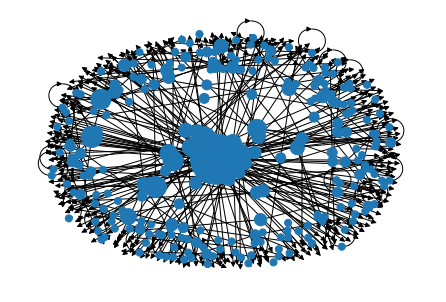

In [13]:
node_sizes = [D.out_degree(n, weight='weight') * 50 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)

Note that in this simplistic drawing, nodes with zero out-strength are not drawn on the diagram because their size is 0. This suits us fine; only the users who have been retweeted are drawn here.

# 6. Twitter mention network

Another Twitter interaction between users occurs when one user mentions another in a tweet by their @screen_name. As an example, consider the following hypothetical tweet from @osome_iu:

> Check out the new research from @IUSICE and @USC_ISI https://...

From this tweet we would create two edges:

    ('osome_iu', 'IUSICE')
    ('osome_iu', 'USC_ISI')

It's up to us which direction we draw these edges, but we should be consistent. In this example, we will draw edges in the direction of attention flow: @osome_iu is giving attention to @IUSICE and @USC_ISI.

## 6.1 Get some tweets

In [ ]:
import itertools

NUM_TWEETS_TO_FETCH = 1000

cursor = twitter.cursor(twitter.search, q='#science', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

## 6.2 Create DiGraph

It's not necessary to first filter out tweets containing user mentions due to a feature of
[Tweet Objects](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object):
every tweet has
[Entities](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#entitiesobject)
which always contains a `'user_mentions'` list, even if that list is empty. Since a tweet may mention more than one user, we need a nested for-loop.

In [14]:
D = nx.DiGraph()

for tweet in search_tweets:
    tweet_sn = tweet['user']['screen_name']
    for user_mention in tweet['entities']['user_mentions']:
        mentioned_sn = user_mention['screen_name']
        
        my_edge = (tweet_sn, mentioned_sn)
        if D.has_edge(*my_edge):
            D.edges[my_edge]['weight'] += 1
        else:
            D.add_edge(*my_edge, weight=1)

## 6.3 Analyze graph

Now that we have this graph, let's ask some questions about it.

### Most  popular users

Since these edges are in the direction of attention flow, in-degree gives us the number of other users mentioning a given user. We can get the user with highest in-degree using the built-in `max` function:

In [15]:
max(D.nodes, key=D.in_degree)

'AntonioParis'

but we can get more context and information from the "top N" users:

In [16]:
sorted(D.in_degree(), key=itemgetter(1), reverse=True)[:5]

[('AntonioParis', 49),
 ('astronomy', 15),
 ('JaviTannhauser', 15),
 ('ChefBoyardee', 12),
 ('illucifer', 11)]

By specifying `weight='weight'` we can instead get the top 5 users by in-strength instead of in-degree:

In [17]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('AntonioParis', 50),
 ('astronomy', 15),
 ('JaviTannhauser', 15),
 ('UN', 14),
 ('ChefBoyardee', 13)]

In some cases these two results will be the same, namely if none of these users has been mentioned multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.

### Conversation drivers

A user mentioning many others in a conversation may be "driving" the conversation and trying to include others in the dialogue. It could also be spam. Let's see who is doing the most mentioning here:

In [18]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('51Prentice', 11),
 ('Tess_blue815', 8),
 ('plantletculture', 6),
 ('Matt_Lucy_JDS', 5),
 ('CastevenLimKHJB', 5)]

### Connectivity

We can ask if the tweets obtained by the search represent one large conversation or many small conversations; broadly speaking, each weakly-connected component represents a conversation.

In [19]:
nx.is_weakly_connected(D)

False

In [20]:
nx.number_weakly_connected_components(D)

300

### Drawing

We can try to draw this graph with the nodes sized by their in-strength:

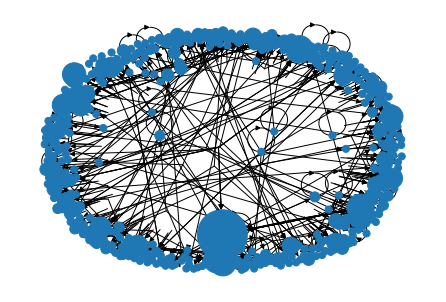

In [21]:
node_sizes = [D.in_degree(n, weight='weight') * 50 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)

Note that in this simplistic drawing, nodes with zero in-strength are not drawn on the diagram because their size is 0. This suits us fine; only the users who have been mentioned are drawn here.